In [4]:
import numpy as np
#import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import numpy.linalg as la
import sys, os
import pickle
#import rbf as RBF
import warnings

import geopandas #for importing data from shapefiles/geodb

import vista #for plotting


In [5]:
from FME import * #import all of the "public" functions from FME

In [6]:
boundary_points = np.zeros((2,3))
boundary_points[0,0] = -20
boundary_points[0,1] = -20
boundary_points[0,2] = -20
boundary_points[1,0] = 20
boundary_points[1,1] = 20
boundary_points[1,2] = 20
mesh = TetMesh('Model','./')
mesh.setup_mesh(boundary_points,nstep=1,n_tetra=100000)
cg = mesh.get_constant_gradient(region=mesh.regions['everywhere'],shape='square')

In [7]:
stratigraphy = DSI(mesh,region='everywhere',shape='rectangular',solver='chol')
# for i in range(-15,15):
#     for j in range(-10,10):
#         stratigraphy.add_point([i,j,3*np.sin(j/5)],0.)
#         stratigraphy.add_point([i,j,3*np.sin(j/5)+1],1.)
# stratigraphy.add_strike_dip_and_value([2.1,0.1,1.1],190.,70.,0.)
stratigraphy.add_strike_dip_and_value([6.1,0.1,1.1],90.,0.,0.)
stratigraphy.add_strike_dip_and_value([6.1,0.1,1.1],90.,0.,0.)
stratigraphy.add_strike_dip_and_value([0.1,0.1,2.1],90.,0.,1.)
# stratigraphy.add_strike_and_dip([6.1,0.1,-15.1],90.,0.)
# stratigraphy.add_strike_and_dip([1.1,0.1,-15.1],90.,0.)
# stratigraphy.add_strike_and_dip([1.1,1.1,-15.1],90.,0.)
cgw = 100 / mesh.n_elements
stratigraphy.setup_interpolator(cg=cgw)
stratigraphy.solve_system(solver='spqr',clear=True)
mesh.update_property('strati',stratigraphy.c)
stratigraphy.export_data_to_vtk('stratig')

Setting up interpolator with 3 value control points 
        3 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.100000


In [10]:
# sphinx_gallery_thumbnail_number = 1
import vista
cmap = plt.cm.get_cmap('viridis',5)

In [8]:
mesh = vista.read('./Model.vtk')

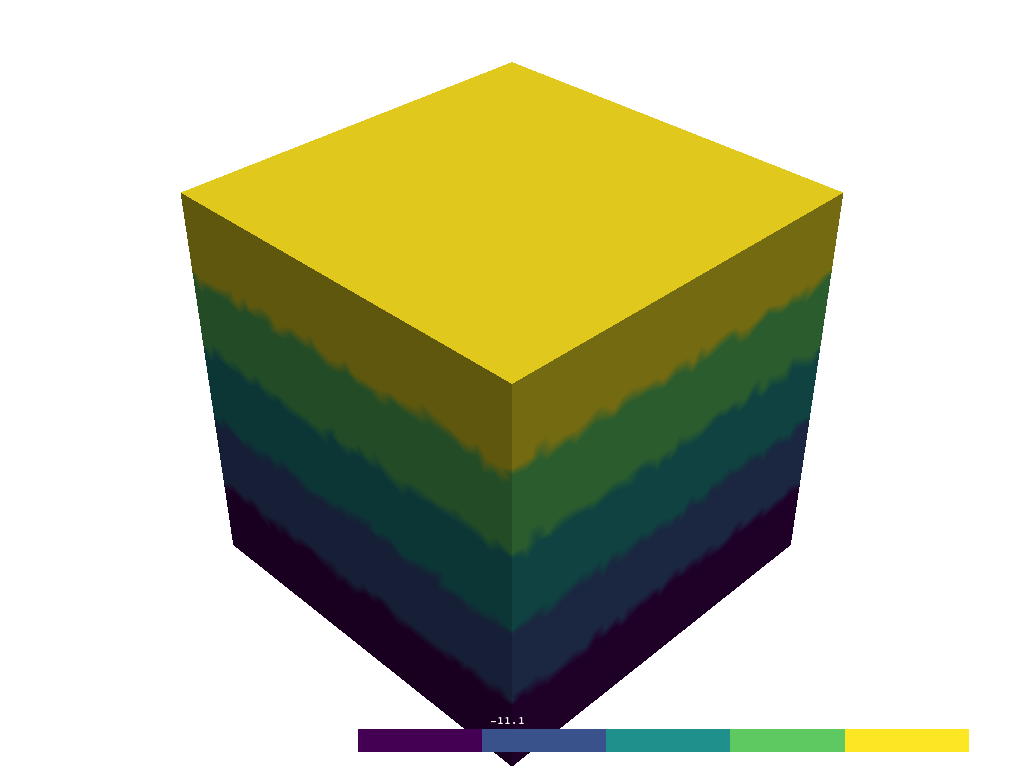

In [23]:
p = vista.Plotter(notebook=True)
p.set_background('white')
p.add_mesh(mesh,cmap=cmap)
p.show()